Link to original opensees website for the problem:
https://opensees.berkeley.edu/wiki/index.php/Time_History_Analysis_of_a_2D_Elastic_Cantilever_Column
<img src="https://opensees.berkeley.edu/wiki/images/e/ea/Example1a_EQ.GIF"></img>

## Units conversion

In [1]:
#length conversion
m = 1.0
inch = m/39.37
ft = 12*inch 

#area conversion
sqinch = inch**2

#ksi to pa
pa = 1.0
kpa = 1000*pa
ksi = 6.89*1000*kpa

#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN


# pound to kg
kg = 1 
pound = 0.453592 * kg

## Model Variables

In [2]:
h = 36.0 * ft
py = -20000*kip

#section
b = 5.0 * inch
A = b**2
E = 3225*ksi
I = 1080000*inch**4

#weight
w = 2000 #Pound force
w_pound = 2000 / 386
mass = w_pound * pound

#analysis names
gravityAnalysis = 'GravityAnalysis'
pushoverAnalysis = 'PushoverAnalysis'
timeHistory = 'TimeHistoryAnalysis'

## Model Definition

In [3]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def getModel():
    ops.wipe()
    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)

    ops.node(1, 0, 0)
    ops.node(2, 0, h)

    ops.fix(1, 1, 1, 1)

    #Mass is assigned at node 2 using mass command. 
    #Since transient analysis is going to be performed for one component of ground motion (horizontal component - x direction),
    #the mass is to be assigned in x direction. 
    #The mass is defined as Weight/g=2000/386=5.18. The vertical and rotational mass are set to zero.
    ops.mass(2, *[mass, 0, 0])

    #Section and element definition
    linTransf = 1
    ops.geomTransf('Linear', linTransf)

    #element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
    ops.element('elasticBeamColumn', 1, *[1,2], A, E, I, linTransf)

In [5]:
def getRecorders(AnalysisName):
    ops.recorder("Node", '-file', f"Outputs/{AnalysisName}/Displacement.txt", '-time', '-closeOnWrite', '-node', 2,'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{AnalysisName}/Reactions.txt", '-time', '-closeOnWrite', '-node', 1,'-dof', *[1,2,3], 'reaction')

    #ops.recorder('Drift', '-file', "Outputs/Drifts.txt", '-time', '-closeOnWrite', '-inode', 1, '-jnode', 2, '-dof', 1, '-perpDirn', 2)

    #recorder Element -file Data/FCol.out -time -ele 1 force
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/Elements_forces.txt', '-time', '-closeOnWrite', '-ele', 1,'-dof', *[1,2,3],  'force')

Since the analysis is static and specific load (2000 kips) is to be applied, load control integrator will be used in this example. The load factor increment ($\lambda$) is set to 0.1 since the full load of 2000 kips is to be applied in 10 analysis steps. For the nth step of analysis the load factor is $\lambda_n = \lambda_{n-1} + \lambda$

In [6]:
def runGravityAnalysis():
    linTS = 1
    ops.timeSeries("Linear", linTS) #tag 1 for linear time series

                        #pattern tag #ts tag
    ops.pattern("Plain", 1, linTS)
    ops.load(2, *[0, py, 0])

    ops.constraints("Plain")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.algorithm("Linear")
    ops.integrator("LoadControl", 0.1)
    ops.analysis("Static")

    ops.record()
    result = ops.analyze(10) #10 steps of analysis to reach load of py
    return result

In [7]:
getModel()
getRecorders(gravityAnalysis)
runGravityAnalysis()

0

Text(0.5, 1.0, 'Model with deformation')

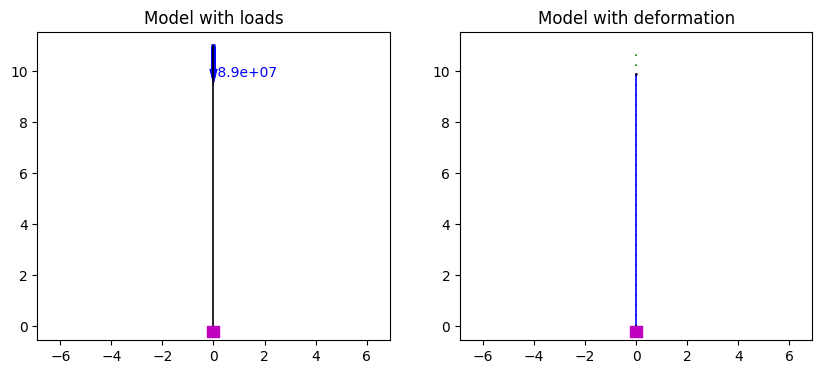

In [8]:
fig, ax = plt.subplots(1, 2 , figsize=(10,4))
ovs.plot_loads_2d(ax=ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Model with loads")
ax[1].set_title("Model with deformation")

<Axes: >

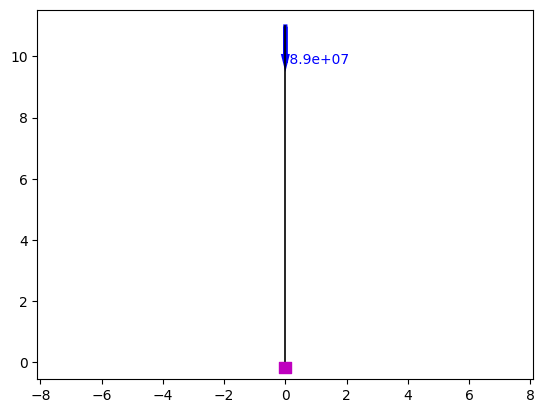

In [25]:
ovs.plot_loads_2d()

# Time History Analysis: Loma Prieta Earthquake

The load pattern for a time history analysis has to be defined first. The load pattern consists of defining an acceleration record of a ground motion that will be applied at the support (node 1). The ground motion used for the analysis is acceleration record from Loma Prieta earthquake (LOMAP) at station CDMG 58373 APEEL 10 - Skyline[1] component A10000. This acceleration record is provided at the beginning of this tutorial. The time interval between the points found in the record (dt) is 0.005 and number of data points found in the record (nPts) is 7990. The Path TimeSeries with id tag 2 is used to define the ground motion time series. The acceleration time history of the recorded ground motion is in units of G and it is thus factored with G = 386 in^2/sec.

In [14]:
ground_motion1 = np.loadtxt("data/A10000.dat").ravel()
ground_motion2 = np.loadtxt("data/BM68elc.dat").ravel()

#### visualizing earthquake pattern

Text(0.5, 1.0, '1968 August 02 Ms7.3 Casiguran Earthquaken')

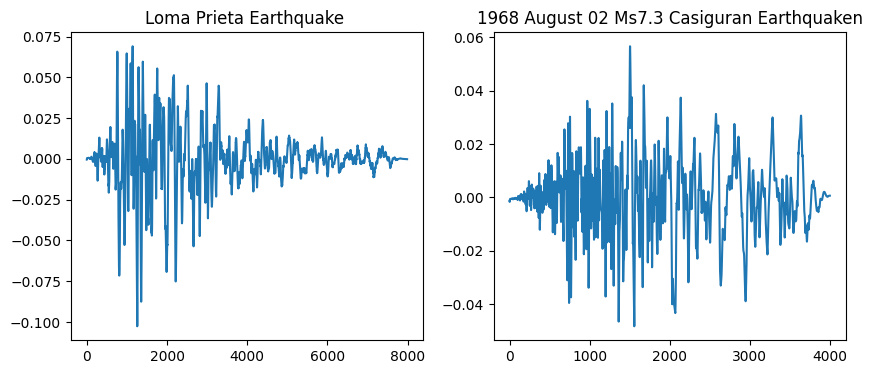

In [16]:
fig, ax = plt.subplots(1, 2 , figsize=(10,4))
ax[0].plot(ground_motion1)
ax[1].plot(ground_motion2)
ax[0].set_title("Loma Prieta Earthquake ")
ax[1].set_title("1968 August 02 Ms7.3 Casiguran Earthquake")

In [17]:
def runTimeHistoryAnalysis(Earthquake_file):
    eqTS = 2 #earthquake time series
    dt = 0.005 
    direction = 1  #corresponds to translation along the global X axis
    #timeSeries('Path', tag, '-dt', dt=0.0, '-values', *values, '-time', *time, '-filePath', filePath='', '-fileTime', fileTime='', '-factor', factor=1.0, '-startTime', startTime=0.0, '-useLast', '-prependZero')
    ground_motion = np.loadtxt(Earthquake_file).ravel()
    
    ops.timeSeries('Path', eqTS, '-dt', dt, '-values', *ground_motion)
    #pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
    ops.pattern('UniformExcitation', 1, direction, '-accel', eqTS)

    #assign damping to the model using rayleigh command
    freq = np.sqrt(ops.eigen('-fullGenLapack', 1)[0])
    dampRatio = 0.02
    ops.rayleigh(0., 0., 0., 2*dampRatio/freq)

    
    ops.constraints("Plain")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.algorithm("Linear")
    ops.integrator("Newmark", 0.5, 0.25)
    ops.analysis("Transient")
    
    ops.record()
    status = ops.analyze(3995, 0.01)
    return status

In [36]:
def plotTimeHistory(Earthquake_Name):
    #plotting displacements of node2 at various points of eqs
    disps = np.loadtxt("Outputs/TimeHistoryAnalysis/Displacement.txt")
    disps
    
    time = disps[:, 0]
    dx = disps[:, 1]
    rot = disps[:, 3]
    
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(time, dx, label="dx at node 2")
    ax.plot(time, rot, label="rotation at node 2")
    plt.legend()
    plt.title(Earthquake_Name)
    plt.show()


In [37]:
lomaPrietaEq = "data/A10000.dat"
casi68Eq = "data/BM68elc.dat"

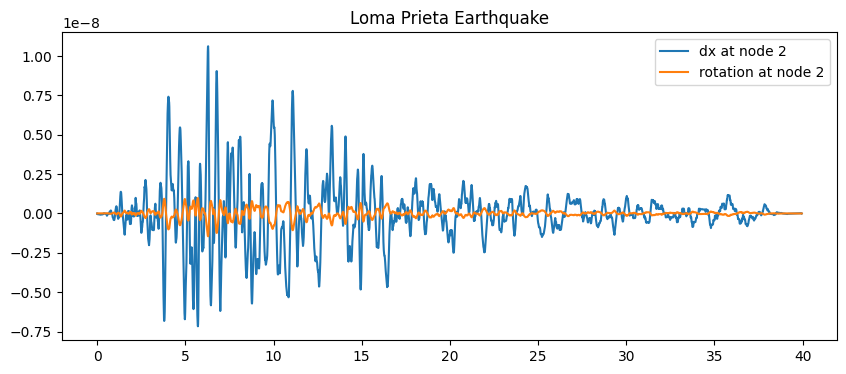

In [38]:
getModel()
getRecorders(timeHistory)
runTimeHistoryAnalysis(lomaPrietaEq)
plotTimeHistory("Loma Prieta Earthquake")

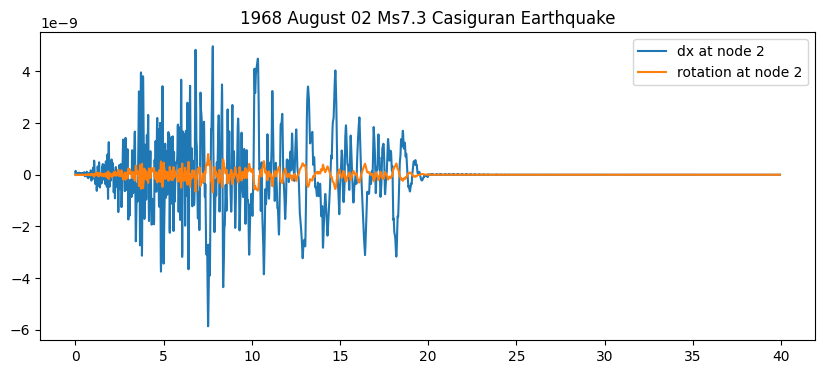

In [40]:
getModel()
getRecorders(timeHistory)
runTimeHistoryAnalysis(casi68Eq)
plotTimeHistory("1968 August 02 Ms7.3 Casiguran Earthquake")